<a href="https://colab.research.google.com/github/MiguelAngeloTr/BIGDATA/blob/main/C3/RFM_Clustering_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

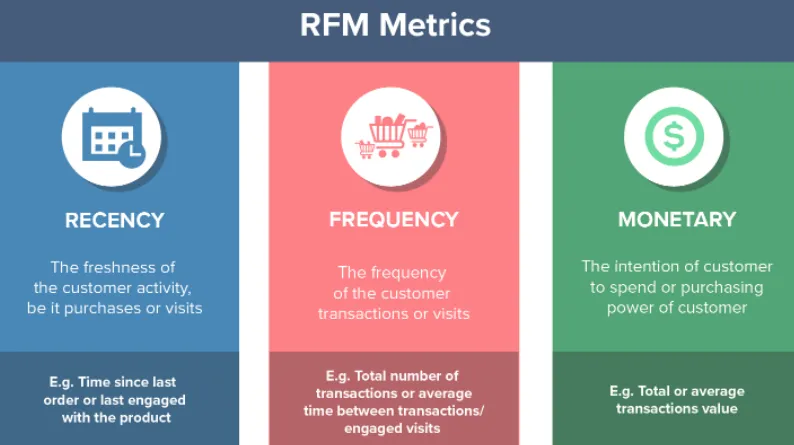

In [ ]:
!pip install -q pyspark
!pip install -q findspark

#Librerias Necesarias

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from google.colab import files
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype

from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.window as W
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans, GaussianMixture

In [ ]:
spark = SparkSession.builder.appName("Clustering PySpark").getOrCreate()
spark

# Lectura Dataset




In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sebmat1","key":"827b2408a40811830d013564b3a462da"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mashlyn/online-retail-ii-uci
!ls # Revisión de archivos descargados

Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
kaggle.json  online-retail-ii-uci.zip  sample_data


In [ ]:
zip_ref = zipfile.ZipFile('online-retail-ii-uci.zip', 'r')
zip_ref.extractall('Data')
zip_ref.close()

In [ ]:
datos = spark.read.csv('/content/Data/online_retail_II.csv',inferSchema=True, header=True)
num_filas, num_col = datos.count(), len(datos.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")
datos.show(5, truncate=False)

Tamaño del DataFrame: 1067371 filas y 8 columnas
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0    |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS               |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |22041    |"RECORD FRAME 7"" SINGLE SIZE "    |48      |2009-12-01 07:45:00|2.1  |13085.0    |United Kingdom|
|489434 |21232    |STRAWBERRY CERAMIC TRINKET BOX     |24      |2009-12-01 07:45:00|1.25 |13085.0    |United Kingdom|
+------

In [ ]:
datos.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



#Exploración de Variables (EDA)

In [ ]:
numeric_features = [t[0] for t in datos.dtypes if t[1] == 'int' or t[1] == 'double']
datos.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Quantity,1067371,9.9388984711033,172.70579407675524,-80995,80995
Price,1067371,4.649387727413342,123.55305872146378,-53594.36,38970.0
Customer ID,824364,15324.63850435002,1697.4644503793263,12346.0,18287.0


In [ ]:
def faltantes(df):
  falta = df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in df.columns])
  return falta.show()

In [ ]:
faltantes(datos)

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|       4382|       0|          0|    0|     243007|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



## Valores faltantes

In [ ]:
datos_f1 = datos.dropna()
num_filas, num_col = datos_f1.count(), len(datos_f1.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")
datos_f1.show(5, truncate=False)

Tamaño del DataFrame: 824364 filas y 8 columnas
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|Description                        |Quantity|InvoiceDate        |Price|Customer ID|Country       |
+-------+---------+-----------------------------------+--------+-------------------+-----+-----------+--------------+
|489434 |85048    |15CM CHRISTMAS GLASS BALL 20 LIGHTS|12      |2009-12-01 07:45:00|6.95 |13085.0    |United Kingdom|
|489434 |79323P   |PINK CHERRY LIGHTS                 |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |79323W   | WHITE CHERRY LIGHTS               |12      |2009-12-01 07:45:00|6.75 |13085.0    |United Kingdom|
|489434 |22041    |"RECORD FRAME 7"" SINGLE SIZE "    |48      |2009-12-01 07:45:00|2.1  |13085.0    |United Kingdom|
|489434 |21232    |STRAWBERRY CERAMIC TRINKET BOX     |24      |2009-12-01 07:45:00|1.25 |13085.0    |United Kingdom|
+-------

In [ ]:
faltantes(datos_f1)

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



## Removiendo productos cancelados

In [ ]:
datos_f2 = datos_f1.filter(~F.col('Invoice').rlike('C'))
num_filas, num_col = datos_f2.count(), len(datos_f2.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")

Tamaño del DataFrame: 805620 filas y 8 columnas


## Remover Duplicados

In [ ]:
num_duplicados = datos_f2.count() - datos_f2.dropDuplicates().count()
print(f"Número de registros duplicados antes de limpiar: {num_duplicados}")
datos_f3 = datos_f2.dropDuplicates()
num_duplicados_desp =  datos_f3.count() - datos_f3.dropDuplicates().count()
print(f"Número de registros duplicados antes de limpiar: {num_duplicados_desp}")
num_filas, num_col = datos_f3.count(), len(datos_f3.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")

Número de registros duplicados antes de limpiar: 26125
Número de registros duplicados antes de limpiar: 0
Tamaño del DataFrame: 779495 filas y 8 columnas


In [ ]:
datos_f4 = datos_f3.filter((F.col('Quantity') > 0) & (F.col('Price') > 0))
num_filas, num_col = datos_f4.count(), len(datos_f4.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")

Tamaño del DataFrame: 779425 filas y 8 columnas


## Limpieza de Outliers

In [ ]:
def replace_outliers_iqr(dataframe, column):
    q1, q3 = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    low_limit, up_limit = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return dataframe.withColumn(
        column,
        F.when(F.col(column) > up_limit, up_limit)
         .when(F.col(column) < low_limit, low_limit)
         .otherwise(F.col(column))
    )

In [ ]:
datos_f5 = replace_outliers_iqr(replace_outliers_iqr(datos_f4, 'Price'), 'Quantity')
datos_f5.select(['Price','Quantity']).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Price,779425,2.6543116245919443,2.1202672047207654,0.001,7.5
Quantity,779425,8.28580812778651,8.083299128774451,1.0,27.0


In [ ]:
def plot_boxplots_comparison(datos_antes, datos_desp, columns):
    df_f1 = datos_antes.select(columns).toPandas()
    df_f2 = datos_desp.select(columns).toPandas()
    df_f1['Source'] = 'antes'
    df_f2['Source'] = 'despues'
    combined_df = pd.concat([df_f1, df_f2])
    plt.figure(figsize=(20, 5))
    for i, column in enumerate(columns):
        plt.subplot(1, 2, i + 1)
        sns.boxplot(x='Source', y=column, data=combined_df)
        plt.title(f'Comparación: {column}')
    plt.show()

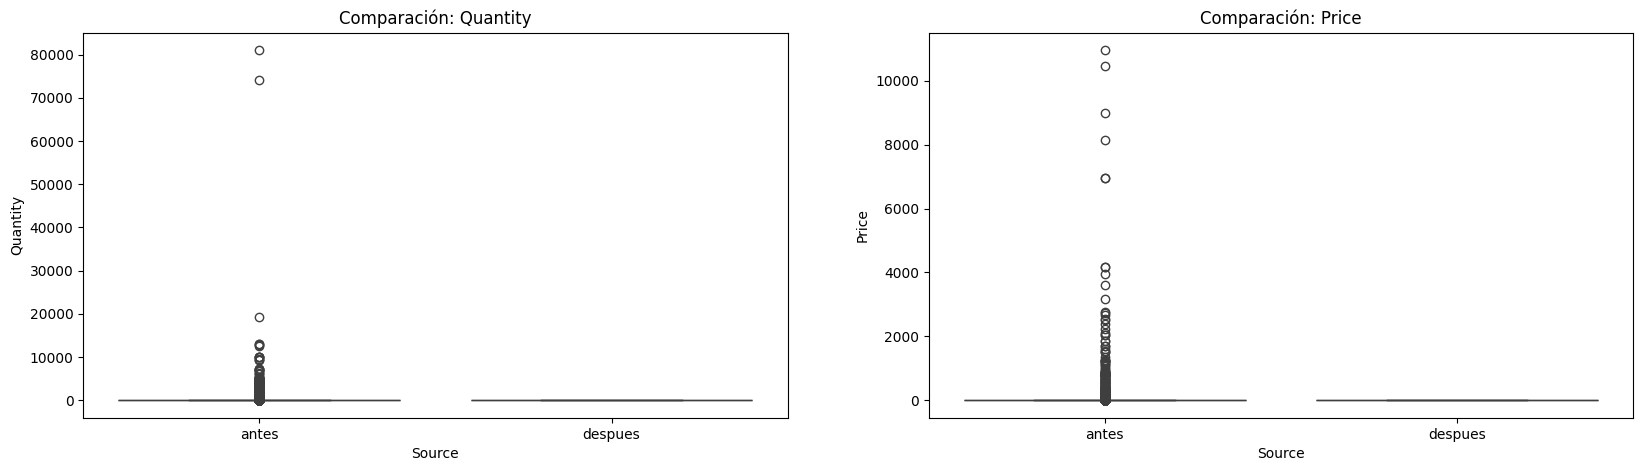

In [ ]:
columns = ["Quantity", "Price"]
plot_boxplots_comparison(datos_f4, datos_f5, columns)

# Creación de Variables RFM

In [ ]:
datos_mon = datos_f5.withColumn('Ingresos', F.col('Quantity') * F.col('Price'))
monetary = (
    datos_mon.groupBy('Customer ID').agg(F.round(F.sum('Ingresos'), 2).alias('Total Ingresos')).orderBy('Customer ID')  # Ordenar por 'Customer ID'
)
monetary.show(5, truncate=False)

+-----------+--------------+
|Customer ID|Total Ingresos|
+-----------+--------------+
|12346.0    |400.94        |
|12347.0    |4473.22       |
|12348.0    |779.73        |
|12349.0    |3347.99       |
|12350.0    |301.9         |
+-----------+--------------+
only showing top 5 rows



In [ ]:
frequency = (
    datos_f5.groupBy('Customer ID')
    .agg(F.countDistinct('Invoice').alias('Unique Invoices'))  # Contar facturas únicas
    .orderBy('Customer ID')  # Ordenar por 'Customer ID'
)
frequency.show(5, truncate=False)

+-----------+---------------+
|Customer ID|Unique Invoices|
+-----------+---------------+
|12346.0    |12             |
|12347.0    |8              |
|12348.0    |5              |
|12349.0    |4              |
|12350.0    |1              |
+-----------+---------------+
only showing top 5 rows



In [ ]:
max_invoice_date = datos_f5.select(F.max('InvoiceDate')).collect()[0][0]
datos_f5 = datos_f5.withColumn('Diferencia', (F.datediff(F.lit(max_invoice_date), F.col('InvoiceDate'))))
# Agrupar por 'Customer ID' y obtener la recencia mínima
recency = (
    datos_f5.groupBy('Customer ID')
    .agg(F.min('Diferencia').alias('Recency'))  # Obtener la diferencia mínima
    .orderBy('Customer ID')  # Ordenar por 'Customer ID'
)
recency.show(5, truncate=False)

+-----------+-------+
|Customer ID|Recency|
+-----------+-------+
|12346.0    |325    |
|12347.0    |2      |
|12348.0    |75     |
|12349.0    |18     |
|12350.0    |310    |
+-----------+-------+
only showing top 5 rows



In [ ]:
RFM = recency.join(frequency, on='Customer ID', how='inner') \
              .join(monetary, on='Customer ID', how='inner')

RFM = RFM.select(
    'Customer ID',
    'Recency',
    'Unique Invoices',
    'Total Ingresos'
).withColumnRenamed('Unique Invoices', 'Frequency') \
 .withColumnRenamed('Total Ingresos', 'Monetary').orderBy('Customer ID')
num_filas, num_col = RFM.count(), len(RFM.columns)
print(f"Tamaño del DataFrame: {num_filas} filas y {num_col} columnas")
RFM.show(5, truncate=False)

Tamaño del DataFrame: 5878 filas y 4 columnas
+-----------+-------+---------+--------+
|Customer ID|Recency|Frequency|Monetary|
+-----------+-------+---------+--------+
|12346.0    |325    |12       |400.94  |
|12347.0    |2      |8        |4473.22 |
|12348.0    |75     |5        |779.73  |
|12349.0    |18     |4        |3347.99 |
|12350.0    |310    |1        |301.9   |
+-----------+-------+---------+--------+
only showing top 5 rows



## Analisis Univariado

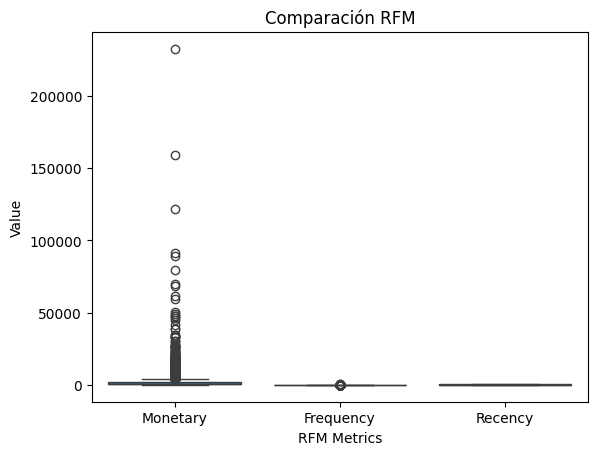

In [ ]:
RFM_df = RFM.toPandas()
sns.boxplot(data=RFM_df[['Monetary', 'Frequency', 'Recency']])
plt.xlabel('RFM Metrics')
plt.ylabel('Value')
plt.title('Comparación RFM')
plt.show()

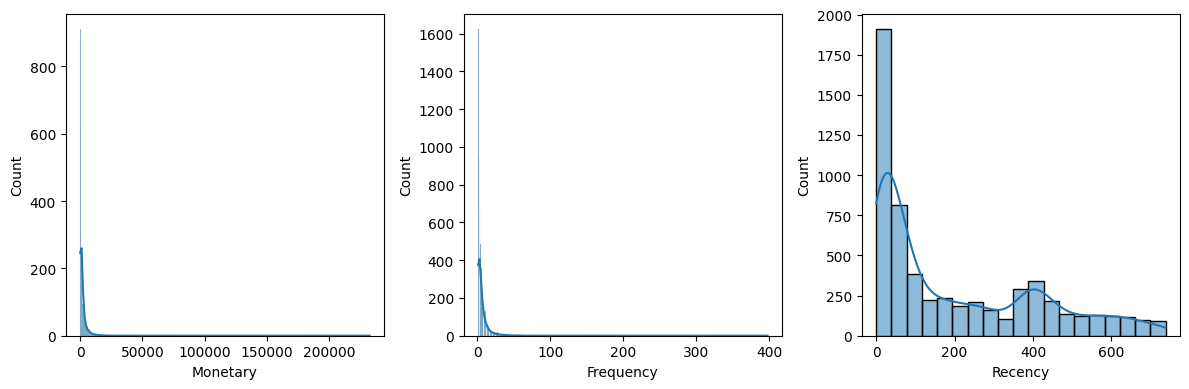

In [ ]:
num_list=['Monetary', 'Frequency', 'Recency']
fig, ax1 = plt.subplots(1, 3, figsize=(12, 4))
cont=0
for column in num_list:
  sns.histplot(RFM_df[column], kde=True, ax=ax1[cont])
  cont += 1
  plt.tight_layout()

In [ ]:
RFM_f2 = replace_outliers_iqr(replace_outliers_iqr(replace_outliers_iqr(RFM, 'Monetary'), 'Frequency'), 'Recency')

In [ ]:
col_to_ignore = ['Customer ID']
cat_car = [c for c, t in RFM_f2.dtypes if t == 'string' and c not in col_to_ignore]
num_car = [c for c, t in RFM_f2.dtypes if t in ['int', 'double'] and c not in col_to_ignore]
print('Cat:',cat_car,'\nNum:', num_car)

Cat: [] 
Num: ['Recency', 'Frequency', 'Monetary']


In [ ]:
assembler = VectorAssembler(inputCols = num_car, outputCol = "features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
preprocessor = Pipeline(stages = [assembler] + [scaler]).fit(RFM_f2)
RFM_f3 = preprocessor.transform(RFM_f2)
selectedCols = ['Customer ID','scaled_features']
RFM_f4 = RFM_f3.select(selectedCols)
RFM_f4.printSchema()

root
 |-- Customer ID: double (nullable = true)
 |-- scaled_features: vector (nullable = true)



In [ ]:
RFM_f4.show(5,truncate=False)

+-----------+--------------------------------------------------------------+
|Customer ID|scaled_features                                               |
+-----------+--------------------------------------------------------------+
|12346.0    |[0.592934607226425,1.5358626756501095,-0.677720415186088]     |
|12347.0    |[-0.9499069928070797,0.670529871981726,2.115191485279921]     |
|12348.0    |[-0.6012152380007458,0.021530269230438315,-0.3938373629975103]|
|12349.0    |[-0.8734814027125408,-0.19480293168665755,1.5309375455635308] |
|12350.0    |[0.5212856165127948,-0.8438025344379452,-0.7519456520950792]  |
+-----------+--------------------------------------------------------------+
only showing top 5 rows



# K-Means

In [ ]:
k_values = list(range(2, 8))
wcss = []

kmeans = KMeans(featuresCol="scaled_features", predictionCol="Cluster", seed=99)

for k in k_values:
  kmeans.setK(k)
  model = kmeans.fit(RFM_f4)
  cost = model.summary.trainingCost
  print(f"Clusters: {k}, WCSS: {cost}")
  wcss.append(cost)

Clusters: 2, WCSS: 7963.778163767555
Clusters: 3, WCSS: 4075.8563718656687
Clusters: 4, WCSS: 3046.1000573390907
Clusters: 5, WCSS: 2639.709022691749
Clusters: 6, WCSS: 2278.5588085239874
Clusters: 7, WCSS: 1899.2731968964033


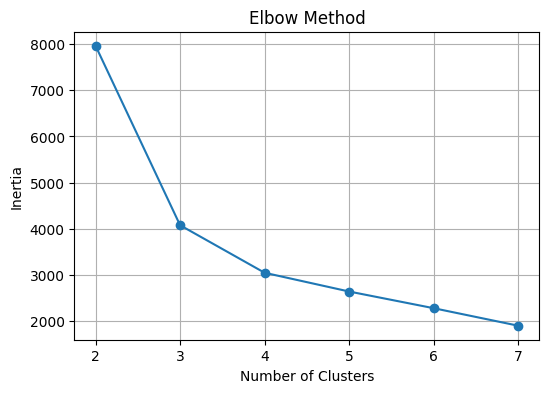

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(k_values, wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

In [ ]:
RFM_perfil = KMeans(k=4, seed=99, featuresCol="scaled_features", predictionCol="Cluster")
model = RFM_perfil.fit(RFM_f4)
predictions = model.transform(RFM_f4)
predictions.show(5,truncate=False)

+-----------+--------------------------------------------------------------+-------+
|Customer ID|scaled_features                                               |Cluster|
+-----------+--------------------------------------------------------------+-------+
|12346.0    |[0.592934607226425,1.5358626756501095,-0.677720415186088]     |3      |
|12347.0    |[-0.9499069928070797,0.670529871981726,2.115191485279921]     |1      |
|12348.0    |[-0.6012152380007458,0.021530269230438315,-0.3938373629975103]|2      |
|12349.0    |[-0.8734814027125408,-0.19480293168665755,1.5309375455635308] |3      |
|12350.0    |[0.5212856165127948,-0.8438025344379452,-0.7519456520950792]  |0      |
+-----------+--------------------------------------------------------------+-------+
only showing top 5 rows



In [ ]:
Pred_KM = predictions.toPandas()
Pred_KM = pd.DataFrame(Pred_KM["scaled_features"].tolist(), columns=["Recency","Frequency","Monetary"])
Pred_KM = pd.concat([Pred_KM,predictions.toPandas()[['Customer ID','Cluster']]], axis=1)

<Axes: xlabel='Cluster', ylabel='Monetary'>

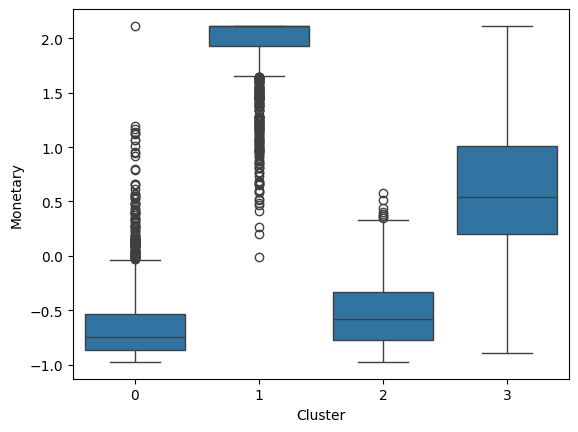

In [ ]:
sns.boxplot(x='Cluster', y='Monetary', data=Pred_KM)

<Axes: xlabel='Cluster', ylabel='Frequency'>

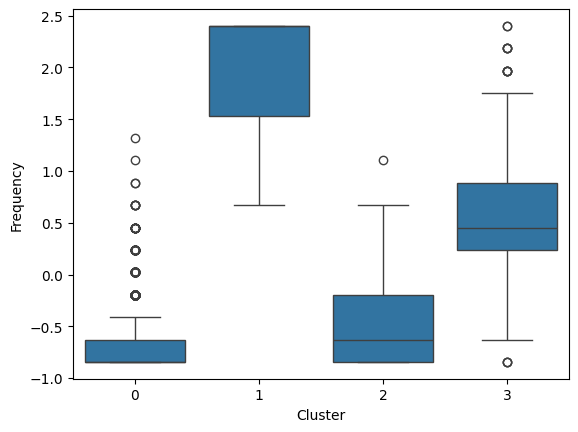

In [ ]:
sns.boxplot(x='Cluster', y='Frequency', data=Pred_KM)

<Axes: xlabel='Cluster', ylabel='Recency'>

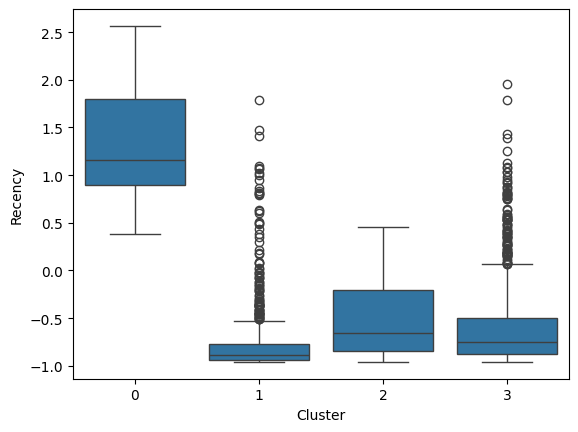

In [ ]:
sns.boxplot(x='Cluster', y='Recency', data=Pred_KM)

In [ ]:
RFM_melt_KM = pd.melt(Pred_KM.reset_index(),
                        id_vars=['Customer ID', 'Cluster'],
                         value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Attribute',
                        value_name='Value')

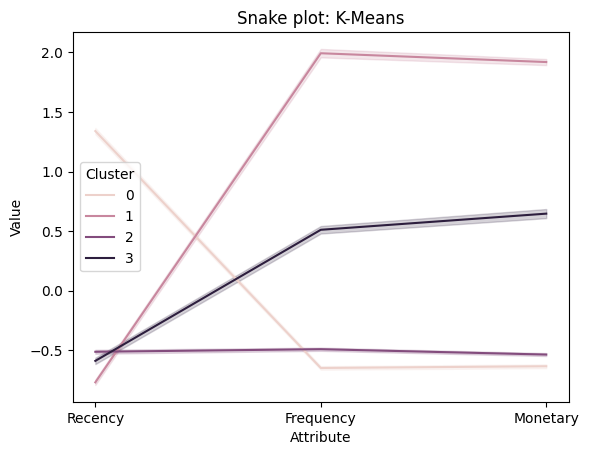

In [ ]:
plt.title('Snake plot: K-Means')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=RFM_melt_KM)
plt.show()

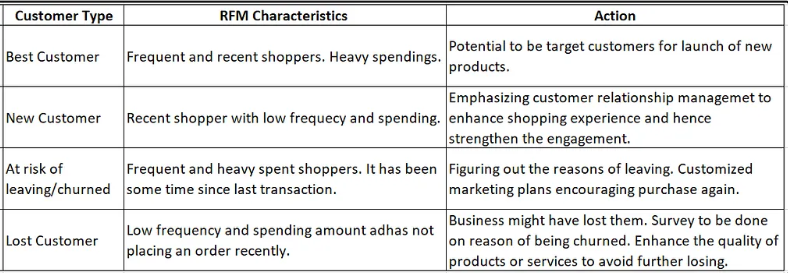

## GMM

In [ ]:
RFM_perfil = GaussianMixture(k=4, seed=99, featuresCol="scaled_features", predictionCol="Cluster")
model = RFM_perfil.fit(RFM_f4)
predictions = model.transform(RFM_f4)
predictions.show(5,truncate=False)

+-----------+--------------------------------------------------------------+---------------------------------------------------------------------------------------+-------+
|Customer ID|scaled_features                                               |probability                                                                            |Cluster|
+-----------+--------------------------------------------------------------+---------------------------------------------------------------------------------------+-------+
|12346.0    |[0.592934607226425,1.5358626756501095,-0.677720415186088]     |[5.163247175142605E-12,0.9999999999845103,5.163247175142605E-12,5.163247175142605E-12] |1      |
|12347.0    |[-0.9499069928070797,0.670529871981726,2.115191485279921]     |[1.3979226983583299E-14,0.018211015822924937,0.9817889841770472,1.3966793918812547E-14]|2      |
|12348.0    |[-0.6012152380007458,0.021530269230438315,-0.3938373629975103]|[0.8446398661271546,0.13529442438626454,0.02006570948655621

In [ ]:
Pred_GMM = predictions.toPandas()
Pred_GMM = pd.DataFrame(Pred_GMM["scaled_features"].tolist(), columns=["Recency","Frequency","Monetary"])
Pred_GMM = pd.concat([Pred_GMM,predictions.toPandas()[['Customer ID','Cluster']]], axis=1)

<Axes: xlabel='Cluster', ylabel='Monetary'>

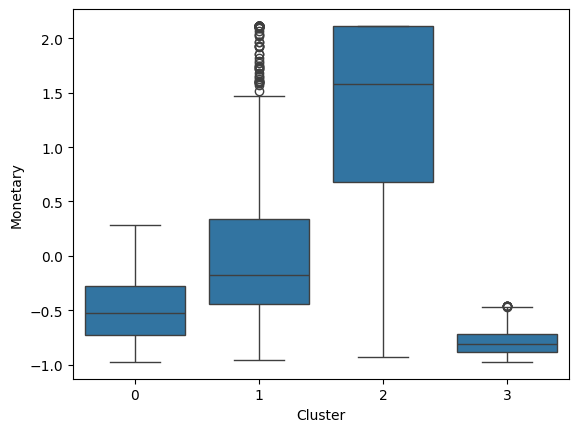

In [ ]:
sns.boxplot(x='Cluster', y='Monetary', data=Pred_GMM)

<Axes: xlabel='Cluster', ylabel='Frequency'>

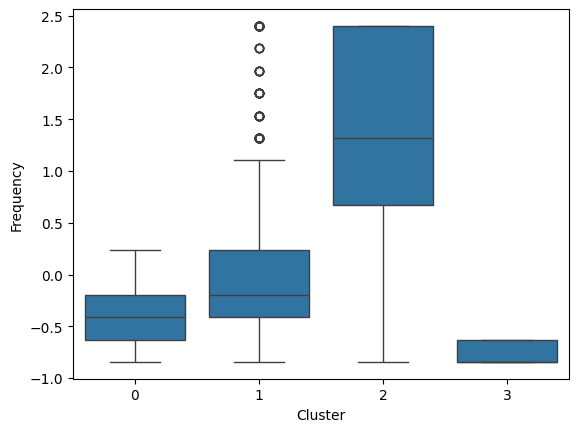

In [ ]:
sns.boxplot(x='Cluster', y='Frequency', data=Pred_GMM)

<Axes: xlabel='Cluster', ylabel='Recency'>

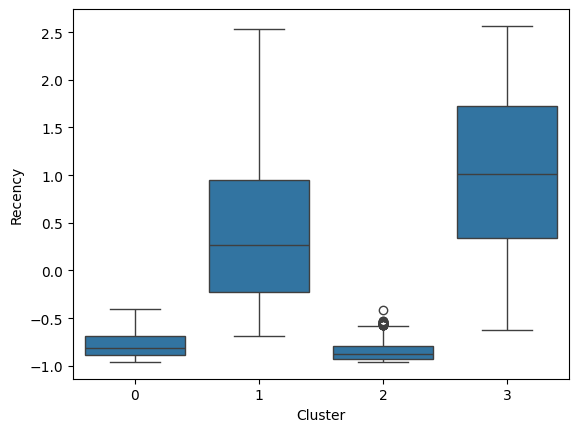

In [ ]:
sns.boxplot(x='Cluster', y='Recency', data=Pred_GMM)

In [ ]:
RFM_melt_GMM =  pd.melt(Pred_GMM.reset_index(),
                        id_vars=['Customer ID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'Monetary'],
                        var_name='Attribute',
                        value_name='Value')

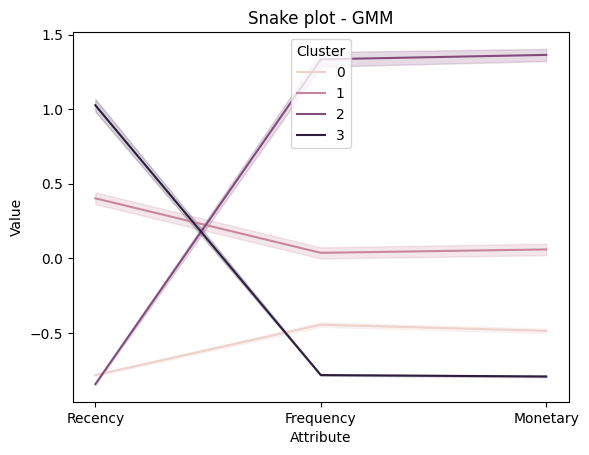

In [ ]:
plt.title('Snake plot - GMM')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=RFM_melt_GMM)
plt.show()

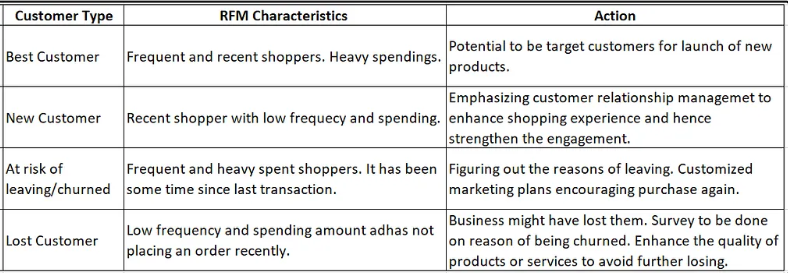